In [7]:
from src.HestonModel import generate_heston_paths
import numpy as np
import esig
import matplotlib.pyplot as plt
import iisignature
import signatory
import torch
from tqdm.auto import tqdm

In [10]:
# constant Heston parameters
kappa = 3
theta = 0.02
v_0 = theta #
rho = 0.75
sigma = 0.6
r = 0.04

S = 100
paths = 10000
steps = 50
T = 1

In [ ]:
# Get Heston prices and volatilises
prices, sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, steps, paths, return_vol=True)

In [12]:
prices.shape

(10000, 50)

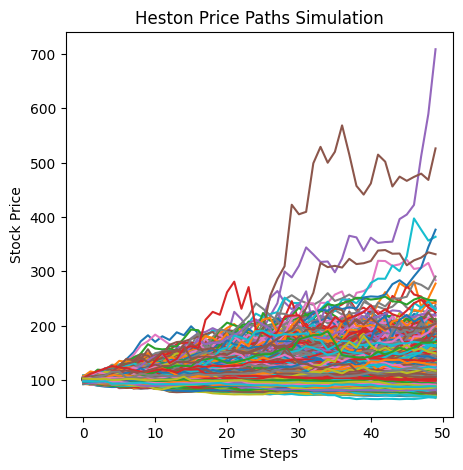

In [13]:
# Plot Heston Price paths
plt.figure(figsize=(5, 5))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


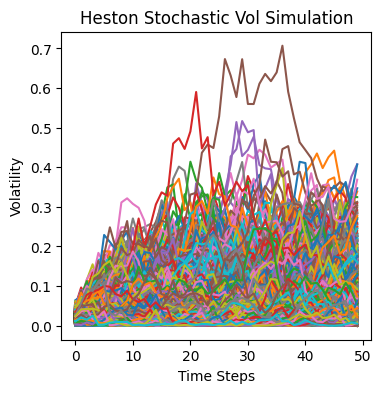

In [14]:
# Plot Heston volatility paths
plt.figure(figsize=(4, 4))
plt.plot(sigs.T)
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.show()

In [15]:
thetas=np.arange(0.01,0.2,0.05) #Long run variance θ
kappas = np.arange(2,4) # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = np.arange(-0.3,0.8,0.3) #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = np.arange(-0.3,0.8,0.3) #Volatility of variance σ
rs = np.arange(0.01,0.10,0.03)

S = 100
paths = 10000
steps = 100
T = 1

In [16]:
sigmas

array([-0.3,  0. ,  0.3,  0.6])

In [17]:
depth_of_sig=2  #level of truncation of signatures
width_of_sig=3  # prices + sigmas + time_array (parameters for signatures)

In [18]:
sig_keys = esig.sigkeys(width_of_sig, depth_of_sig)
sig_dim=signatory.signature_channels(width_of_sig,depth_of_sig)

In [19]:
sig_keys

' () (1) (2) (3) (1,1) (1,2) (1,3) (2,1) (2,2) (2,3) (3,1) (3,2) (3,3)'

In [20]:
# define time_array and empty tensor for prices and sigmas, signatures and expected signatures
time_array = np.arange(steps)
prices_and_sigs_with_time_tensor = torch.zeros((paths,steps, width_of_sig ))
number_of_loops=thetas.shape[0]*kappas.shape[0]*rhos.shape[0]*sigmas.shape[0]*rs.shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [21]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for r in rs:
        for rho in rhos:
            for sigma in sigmas:
                for kappa in kappas:
                    for theta in thetas:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([512, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([512, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [ ]:
results_3=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_3=results_3[0]
Exp_signatures_results_3=results_3[1]

In [23]:
Exp_signatures_results_3.shape

torch.Size([512, 12])

In [24]:
signatures_results_3.shape

torch.Size([512, 10000, 12])

In [25]:
signatures_results_3[0].shape

torch.Size([10000, 12])

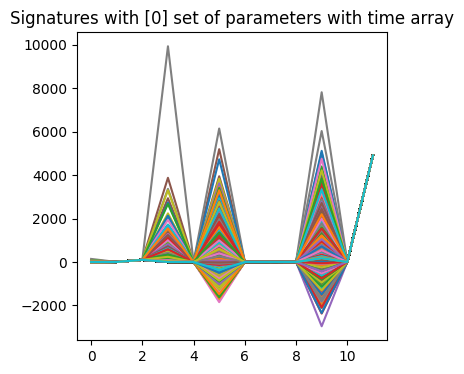

In [26]:
plt.figure(figsize=(4, 4))
plt.plot(signatures_results_3[0].T)  #there are 512 sets of parameters
plt.title("Signatures with [0] set of parameters with time array")
plt.show()

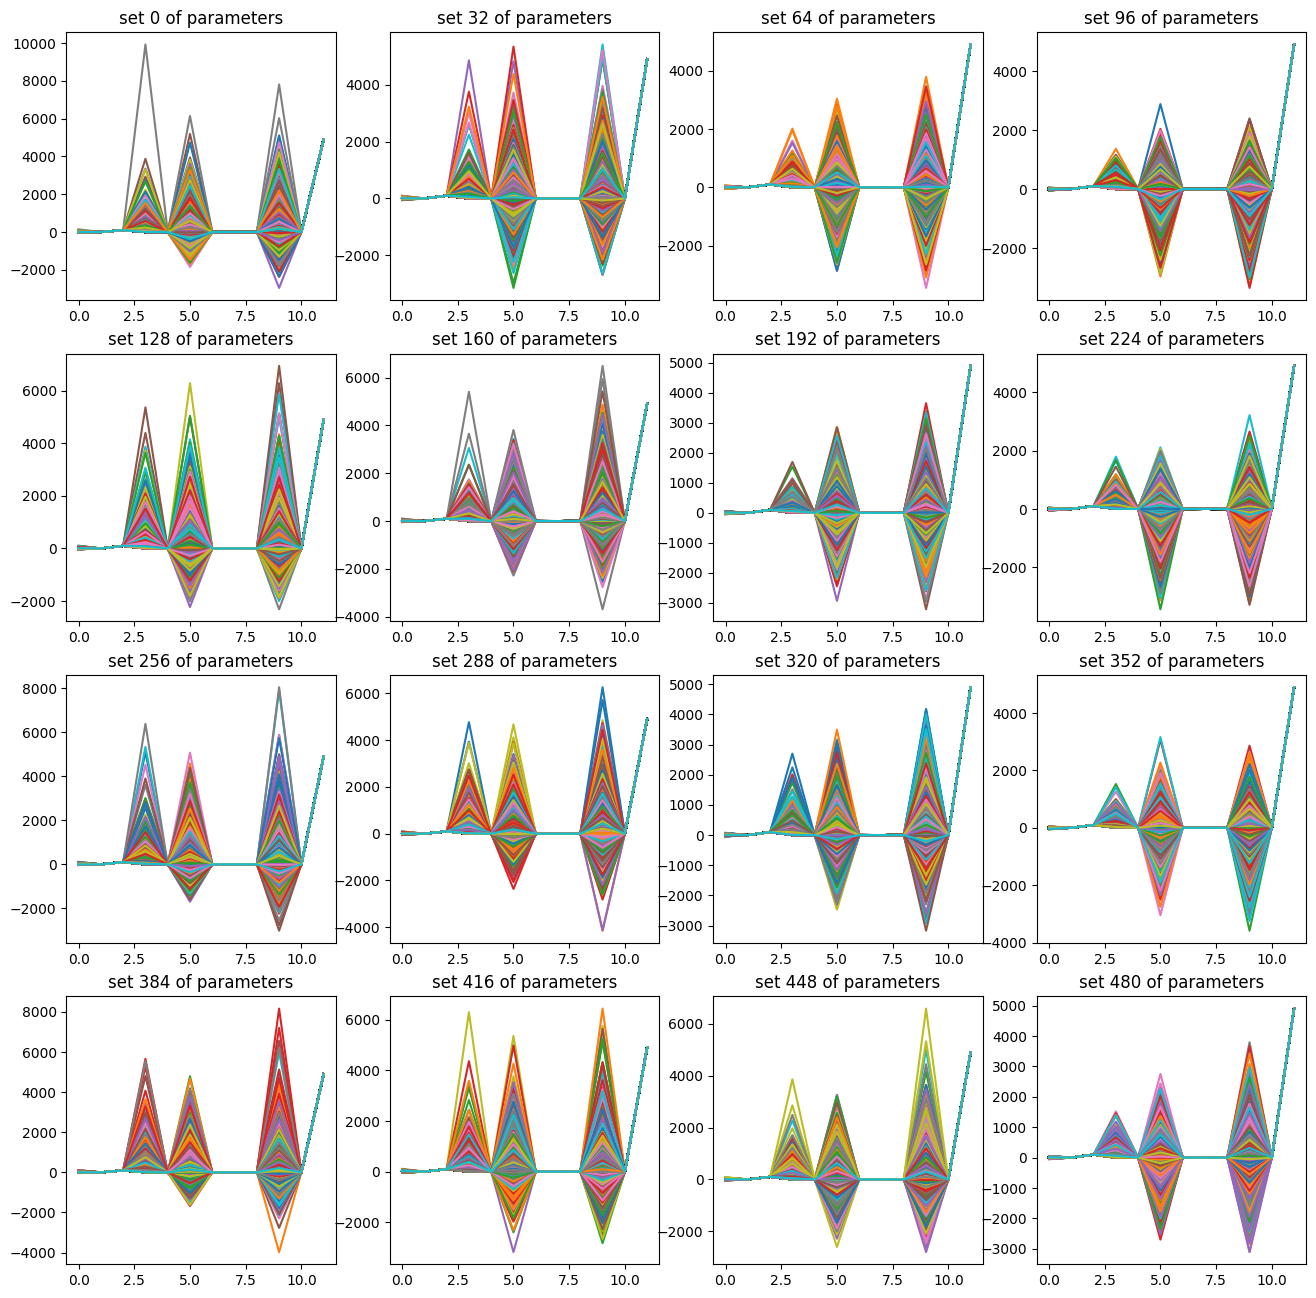

In [27]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text("set " + str(i*32)+" of parameters")
    ax.plot(signatures_results_3[i*32].T)
#     Plot 10000 signatures for each set of parameters
#     There are big changes on each plot, which are formed on the signature keys (1,1), (1,3), (3,1)

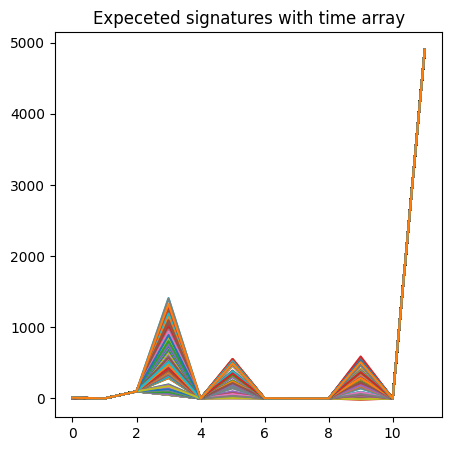

In [28]:
plt.figure(figsize=(5, 5))
plt.plot(Exp_signatures_results_3.T[:])
plt.title("Expeceted signatures with time array")
plt.show()
# Plot 512 expected signatures

In [29]:
Exp_signatures_results_3.T.shape

torch.Size([12, 512])

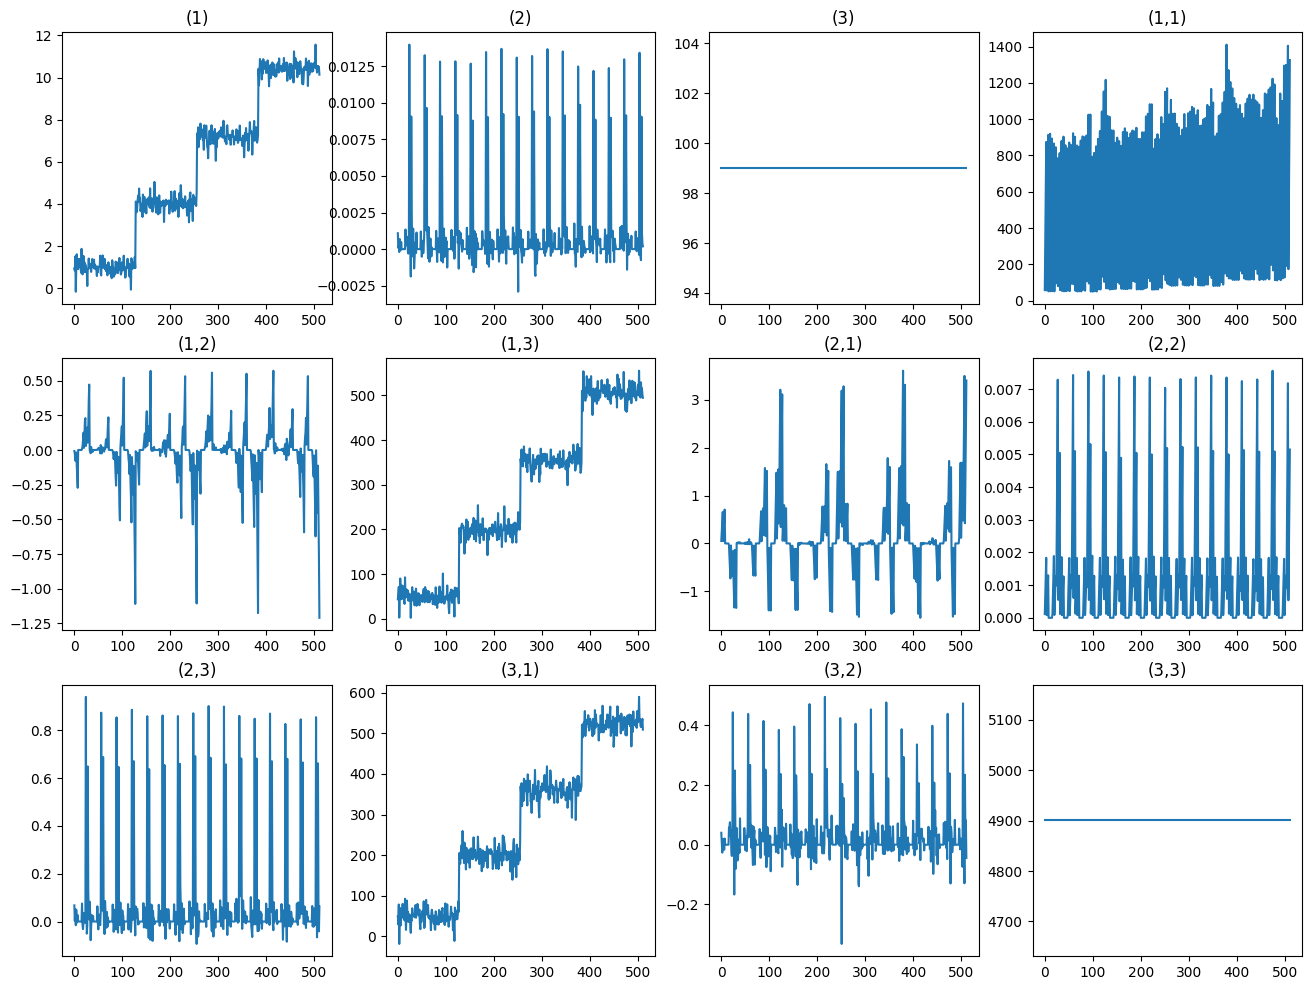

In [30]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_3.T[i])
#     For each key of the signature, plot the evolving Expected Signature depending on the parameter set 0-512
#     For time keys like (3) and (3,3) we have constant, since it does not change from the parameters
#     Keys (1), (1,3) and (3,1) have similar plots, which have big jumps in the same places. But not (1,1)
#     Keys (1,2) and (2,1) looks like vice versa plots, but with different scales


# But if you change the order of parameters in the function "signatures_calculations_with_timearray",
# the overall graph of the Expected Signatures "Expeceted signatures with time array" will not change much, the pattern will remain the same.
# However, the graphs for each key of the signature will change, but retain the dependent similarity
# (namely, between (3) and (3,3), or Keys (1), (1,3) and (3,1), or (1,2) and (2,1) as was written above)

In [31]:
Exp_signatures_results_3.T[0].shape

torch.Size([512])

In [32]:
Exp_signatures_results_3.shape

torch.Size([512, 12])

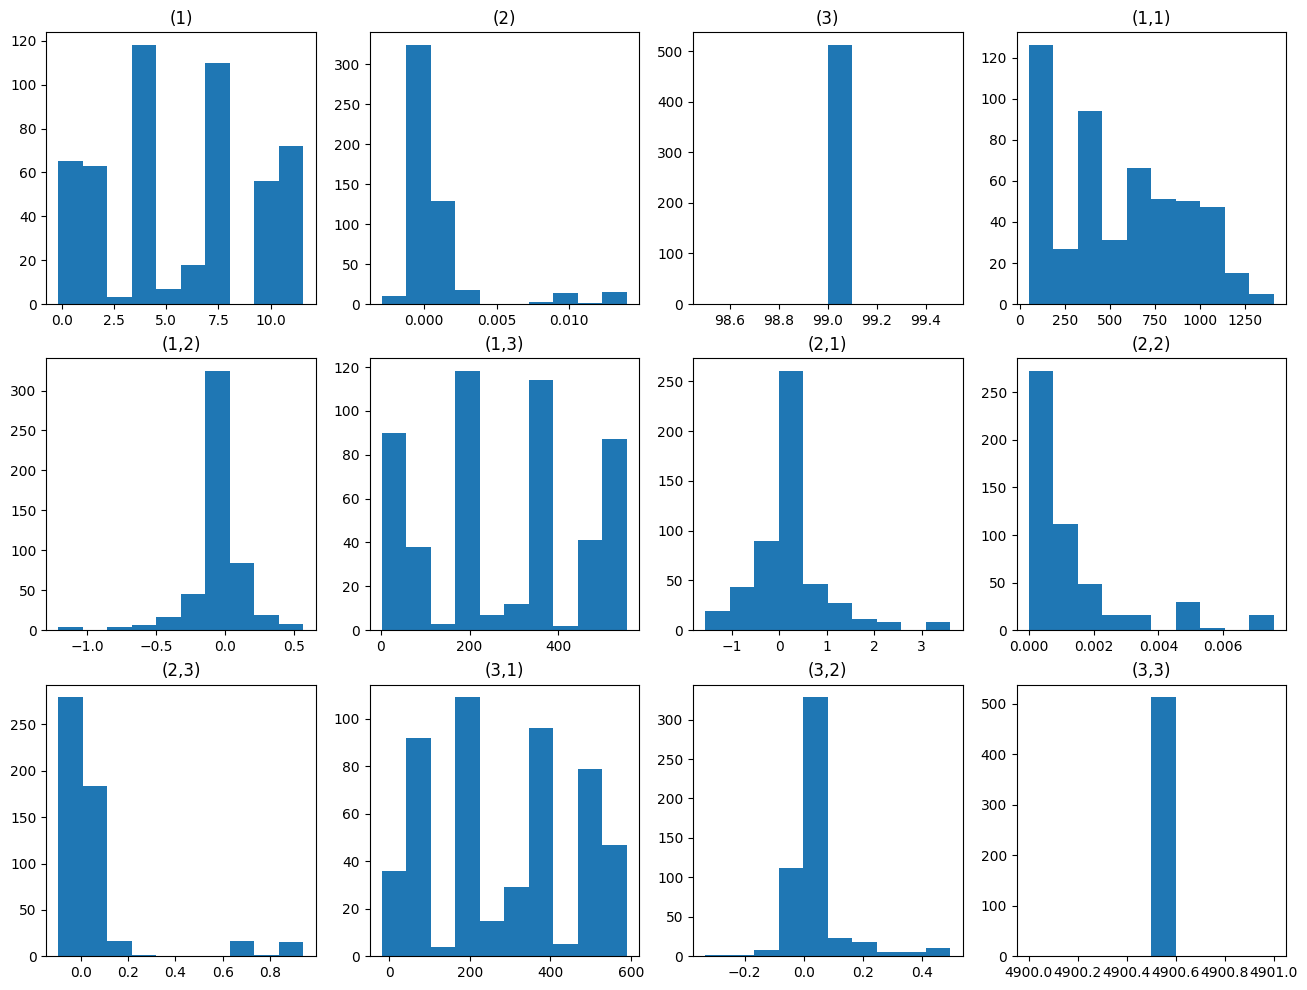

In [33]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.hist(Exp_signatures_results_3.T[i])

# Although, if you change the order of parameters in the function "signatures_calculations_with_timearray",
# the graphs of each Expected signature key are different, their histograms are similar.

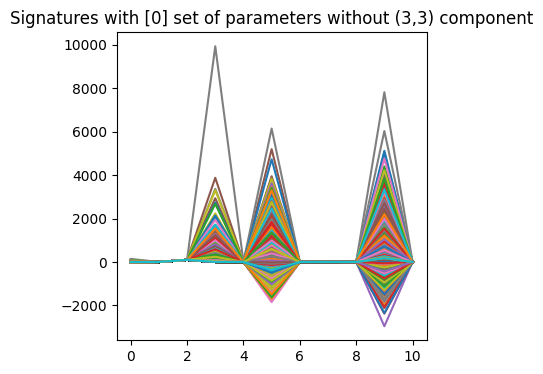

In [34]:
plt.figure(figsize=(4, 4))
plt.plot(signatures_results_3[0].T[:-1])  #there are 512 sets of parameters #excluded the last component to better understand the graph, since its value is too big
plt.title("Signatures with [0] set of parameters without (3,3) component")
plt.show()

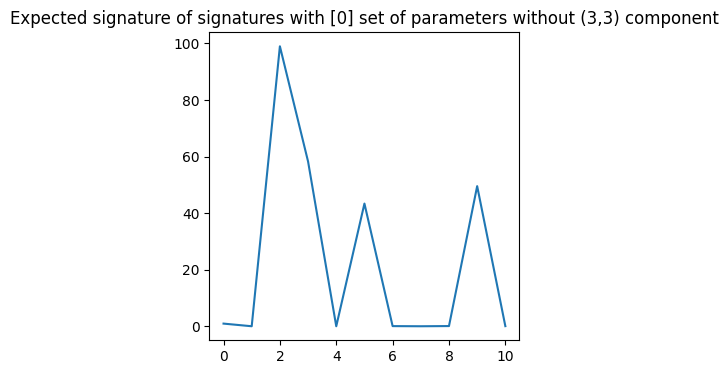

In [35]:
plt.figure(figsize=(4, 4))
plt.plot(Exp_signatures_results_3[0].T[:-1])  #there are 512 sets of parameters #exclude last component, since its value is too big
plt.title("Expected signature of signatures with [0] set of parameters without (3,3) component")
plt.show()

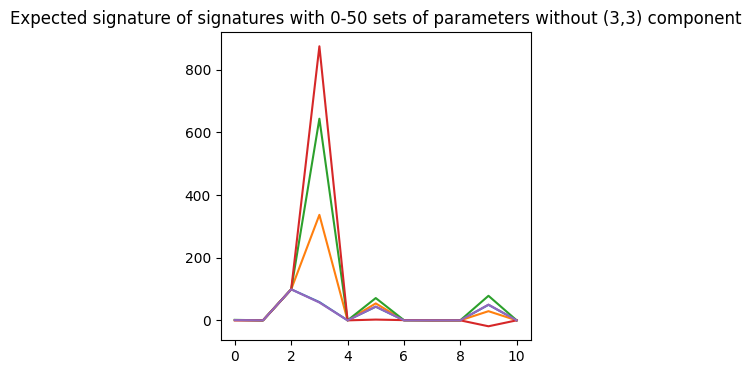

In [53]:
plt.figure(figsize=(4, 4))
plt.plot(Exp_signatures_results_3[:5].T[:-1])  #there are 512 sets of parameters #exclude last component, since its value is too big
plt.title("Expected signature of signatures with 0-50 sets of parameters without (3,3) component")
plt.show()

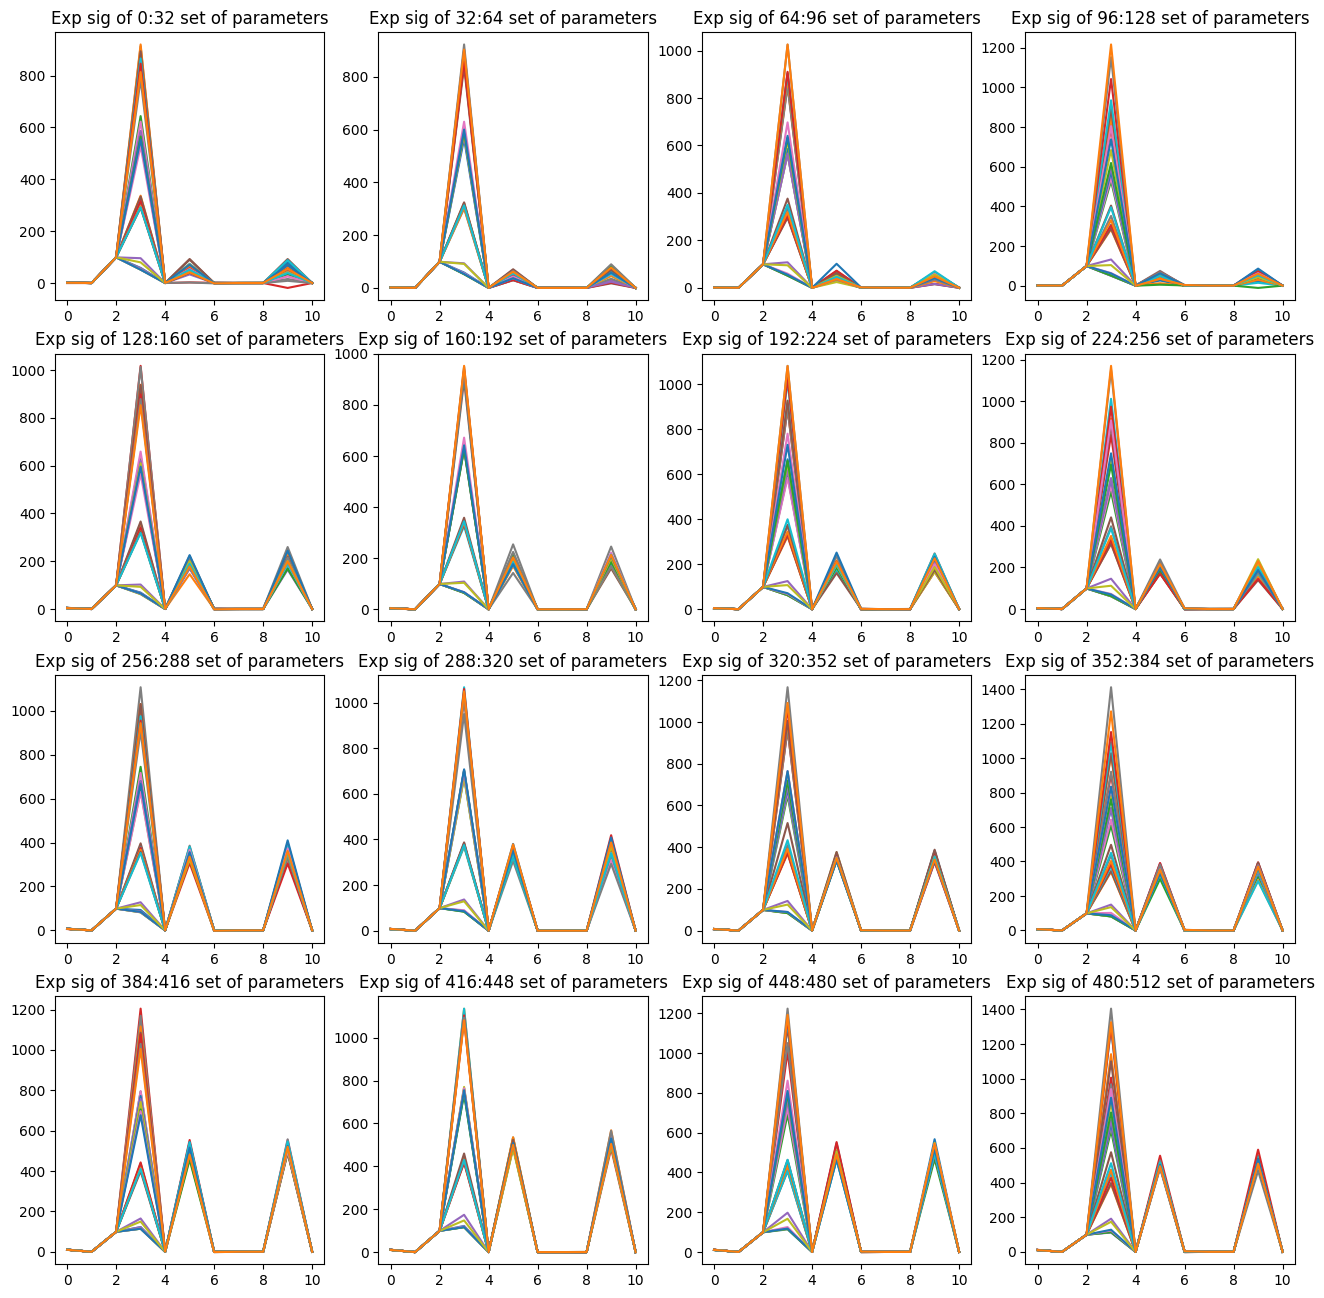

In [54]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text("Exp sig of "  + str(i*32)+":"+ str((i+1)*32)+" set of parameters")
    ax.plot(Exp_signatures_results_3[i*32:(i+1)*32].T[:-1]) #for better illustration exclude last component, since its value is too big